<a href="https://colab.research.google.com/github/morii-ju/LSTM_RNN_Tutorials_with_Demo/blob/master/demo06.5-object-detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TorchVision Object Detection Finetuning

This is a lightly edited version of a [PyTorch tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).


## Defining the Dataset

The reference scripts for training object detection, instance
segmentation and person keypoint detection allows for easily supporting
adding new custom datasets. The dataset should inherit from the standard
``torch.utils.data.Dataset`` class, and implement ``__len__`` and
``__getitem__``.

The only specificity that we require is that the dataset ``__getitem__``
should return a tuple:

-  image: :class:`torchvision.tv_tensors.Image` of shape ``[3, H, W]``, a pure tensor, or a PIL Image of size ``(H, W)``
-  target: a dict containing the following fields

   -  ``boxes``, :class:`torchvision.tv_tensors.BoundingBoxes` of shape ``[N, 4]``:
      the coordinates of the ``N`` bounding boxes in ``[x0, y0, x1, y1]`` format, ranging from ``0``
      to ``W`` and ``0`` to ``H``
   -  ``labels``, integer :class:`torch.Tensor` of shape ``[N]``: the label for each bounding box.
      ``0`` represents always the background class.
   -  ``image_id``, int: an image identifier. It should be
      unique between all the images in the dataset, and is used during
      evaluation
   -  ``area``, float :class:`torch.Tensor` of shape ``[N]``: the area of the bounding box. This is used
      during evaluation with the COCO metric, to separate the metric
      scores between small, medium and large boxes.
   -  ``iscrowd``, uint8 :class:`torch.Tensor` of shape ``[N]``: instances with ``iscrowd=True`` will be
      ignored during evaluation.
   -  (optionally) ``masks``, :class:`torchvision.tv_tensors.Mask` of shape ``[N, H, W]``: the segmentation
      masks for each one of the objects



### Writing a custom dataset for PennFudan

Let’s write a dataset for the PennFudan dataset. After [downloading and
extracting the zip
file](https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip), we
have the following folder structure:

   PennFudanPed/

     PedMasks/
       FudanPed00001_mask.png
       FudanPed00002_mask.png
       FudanPed00003_mask.png
       FudanPed00004_mask.png
       ...
     PNGImages/
       FudanPed00001.png
       FudanPed00002.png
       FudanPed00003.png
       FudanPed00004.png

So each image has a corresponding
segmentation mask, where each color correspond to a different instance.
Let’s write a :class:`torch.utils.data.Dataset` class for this dataset.
In the code below, we are wrapping images, bounding boxes and masks into
``torchvision.TVTensor`` classes so that we will be able to apply torchvision
built-in transformations ([new Transforms API](https://pytorch.org/vision/stable/transforms.html))
for the given object detection and segmentation task.
Namely, image tensors will be wrapped by :class:`torchvision.tv_tensors.Image`, bounding boxes into
:class:`torchvision.tv_tensors.BoundingBoxes` and masks into :class:`torchvision.tv_tensors.Mask`.
As ``torchvision.TVTensor`` are :class:`torch.Tensor` subclasses, wrapped objects are also tensors and inherit the plain
:class:`torch.Tensor` API. For more information about torchvision ``tv_tensors`` see
[this documentation](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_getting_started.html#what-are-tvtensors).



In [4]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        # the directory
        self.root = root
        # all transfomations that has been done
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That’s all for the dataset. Now let’s define a model that can perform
predictions on this dataset.

## Defining your model

In this tutorial, we will be using [Mask
R-CNN](https://arxiv.org/abs/1703.06870)_, which is based on top of
[Faster R-CNN](https://arxiv.org/abs/1506.01497)_. Faster R-CNN is a
model that predicts both bounding boxes and class scores for potential
objects in the image.

<img src="https://production-media.paperswithcode.com/methods/new_arch.jpg">

Mask R-CNN adds an extra branch
into Faster R-CNN, which also predicts segmentation masks for each
instance.

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-23_at_7.44.34_PM.png">

There are two common
situations where one might want
to modify one of the available models in TorchVision Model Zoo. The first
is when we want to start from a pre-trained model, and just finetune the
last layer. The other is when we want to replace the backbone of the
model with a different one (for faster predictions, for example).

Today, we'll be replacing the last layers that create masking and bounding box predictions.



In [3]:
# get the pretrained models
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

That’s it, this will make ``model`` be ready to be trained and evaluated
on your custom dataset.

## Putting everything together

In ``references/detection/``, we have a number of helper functions to
simplify training and evaluating detection models. Here, we will use
``references/detection/engine.py`` and ``references/detection/utils.py``.
Just download everything under ``references/detection`` to your folder and use them here.





In [5]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")


0

We'll also access the data set. Remember to download the `PennFudanPed` [data set](https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip). Once you unzip the folder, upload it to your Google Drive in the folder `data`.

In [8]:
from google.colab import drive
drive.mount('/content/drive')
filename = '/content/drive/My Drive/data/PennFudanPed'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
from torchvision.transforms import v2 as T


def get_transform(train):
    # data pre-processing for the datasets
    transforms = []
    if train:
        # adding variation
        transforms.append(T.RandomHorizontalFlip(0.5))
    # make the input continuous and scale 0-1
    transforms.append(T.ToDtype(torch.float, scale=True))
    # require tensorflow and autograd
    transforms.append(T.ToPureTensor())
    # combine these transformations into one single, sequential pipeline
    return T.Compose(transforms)


# Testing ``forward()`` method (Optional)
# ---------------------------------------
#
# Before iterating over the dataset, it's good to see what the model
# expects during training and inference time on sample data.
import utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset(filename, get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2, # each batch contains 2 images
    shuffle=True, # shuffle to improve generalization
    num_workers=4, # the number of subprocesses
    collate_fn=utils.collate_fn
)

# For Training
# yield next batch of the image
images, targets = next(iter(data_loader))
# image: tensors for the images in this batch
images = list(image for image in images)
# create a list of disctionaries containing the annotation data
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
# generate two random images
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'loss_classifier': tensor(0.1873, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0192, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0208, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0019, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


Let’s now write the main function which performs the training and the
validation:



In [10]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
# apply data augmentation for this set
dataset = PennFudanDataset(filename, get_transform(train=True))
dataset_test = PennFudanDataset(filename, get_transform(train=False))

# split the dataset in train and test set
# create a random permutation of the indices
indices = torch.randperm(len(dataset)).tolist()
# 50: 50 split
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
# extract parameters with label, only these will be optimized
params = [p for p in model.parameters() if p.requires_grad]
# use SGD
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
# to reduce the learning rate every 3 steps, help converge
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it for 5 epochs
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 166MB/s]
/content/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/60]  eta: 0:06:45  lr: 0.000090  loss: 5.1557 (5.1557)  loss_classifier: 0.7044 (0.7044)  loss_box_reg: 0.1975 (0.1975)  loss_mask: 4.2473 (4.2473)  loss_objectness: 0.0060 (0.0060)  loss_rpn_box_reg: 0.0005 (0.0005)  time: 6.7580  data: 3.2314  max mem: 2002
Epoch: [0]  [10/60]  eta: 0:00:54  lr: 0.000936  loss: 1.3711 (2.6741)  loss_classifier: 0.3323 (0.4185)  loss_box_reg: 0.2527 (0.2628)  loss_mask: 0.8945 (1.9690)  loss_objectness: 0.0133 (0.0195)  loss_rpn_box_reg: 0.0037 (0.0044)  time: 1.0946  data: 0.3024  max mem: 2761
Epoch: [0]  [20/60]  eta: 0:00:33  lr: 0.001783  loss: 0.8088 (1.7327)  loss_classifier: 0.2041 (0.2985)  loss_box_reg: 0.2523 (0.2546)  loss_mask: 0.3347 (1.1583)  loss_objectness: 0.0109 (0.0164)  loss_rpn_box_reg: 0.0045 (0.0049)  time: 0.5458  data: 0.0139  max mem: 3144
Epoch: [0]  [30/60]  eta: 0:00:22  lr: 0.002629  loss: 0.5991 (1.3477)  loss_classifier: 0.1209 (0.2307)  loss_box_reg: 0.2229 (0.2418)  loss_mask: 0.2278 (0.8560)  loss_ob

So after one epoch of training, we obtain a COCO-style mAP > 50, and
a mask mAP of 65.

But what do the predictions look like? Let’s take one image in the
dataset and verify

<img src="file://../../_static/img/tv_tutorial/tv_image05.png">




In [11]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from PIL import Image
import requests
import torchvision.transforms.functional as transform

url = "https://images.pexels.com/photos/109919/pexels-photo-109919.jpeg?cs=srgb&dl=pexels-kaique-rocha-109919.jpg&fm=jpg"
PIL_image = Image.open(requests.get(url, stream=True).raw)


image = transform.to_tensor(PIL_image)

eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


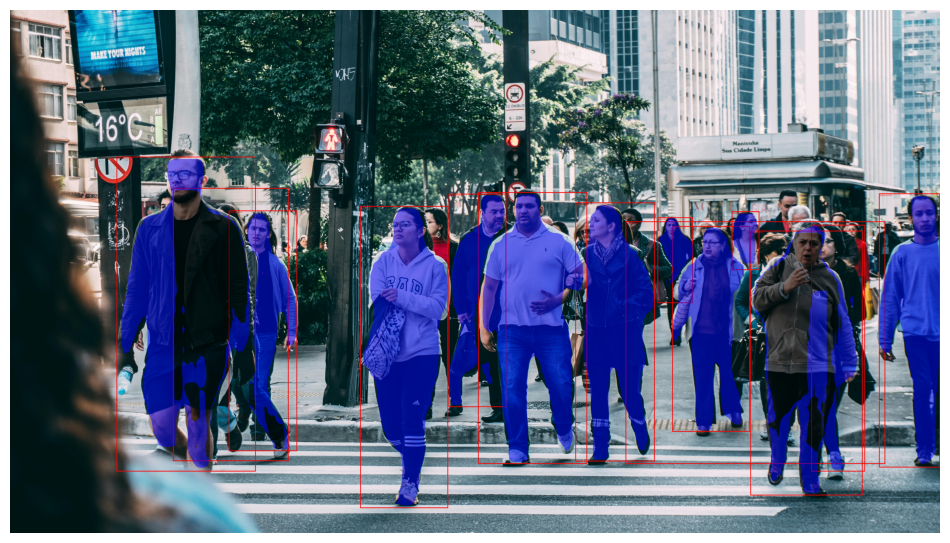

In [12]:
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, width=5, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
plt.axis('off')
plt.show()

The results look good!

## Wrapping up

In this tutorial, you have learned how to create your own training
pipeline for object detection models on a custom dataset. For
that, you wrote a ``torch.utils.data.Dataset`` class that returns the
images and the ground truth boxes and segmentation masks. You also
leveraged a Mask R-CNN model pre-trained on COCO train2017 in order to
perform transfer learning on this new dataset.

For a more complete example, which includes multi-machine / multi-GPU
training, check ``references/detection/train.py``, which is present in
the torchvision repository.

You can download a full source file for this tutorial
[here](https://pytorch.org/tutorials/_static/tv-training-code.py)_.
